In [2]:
import torch as th
import matplotlib.pyplot as plt
%matplotlib inline
import numpy

In [10]:
def random(N): return th.rand(N)
def pm(N): return (random(N)<0.5).float()*2 - 1
def betap(N, alpha=0.2): return  th.from_numpy(numpy.random.beta(alpha, alpha+1, N)).float()
def betan(N, alpha=0.2): return  -betap(N, alpha) 
def betapn(N, alpha=0.2): return  betap(N, alpha) * pm(N)
def unifp(N, alpha=0.2): return (random(N)<alpha).float() * random(N)
def unifn(N, alpha=0.2): return -unifp(N, alpha)
def unifpn(N, alpha=0.2): return unifp(N, alpha) * pm(N)
def binp(N, alpha=0.2): return (random(N)<alpha).float()
def binn(N, alpha=0.2): return -1 * binp(N, alpha)
def binpn(N, alpha=0.2): return binp(N, alpha) * pm(N)

In [11]:
print("betap", 0.2,  betap(100000).mean())
print("betapn", 0.2,  betapn(100000).mean())
print("unifp", 0.2,  unifp(100000).mean())
print("unifpn", 0.2,  unifpn(100000).mean())
print("binp", 0.2,  binp(100000).mean())
print("binpn", 0.2,  binpn(100000).mean())

betap 0.2 0.14234353120912355
betapn 0.2 0.0006852744790219107
unifp 0.2 0.10063080361664295
unifpn 0.2 0.0012106143492460252
binp 0.2 0.1985
binpn 0.2 -0.00046


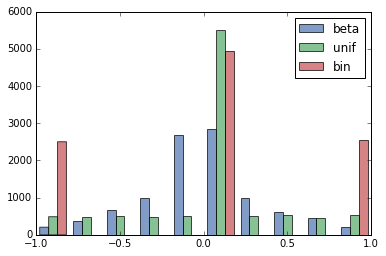

In [17]:
import numpy as np
plt.style.use('seaborn-deep')

x = betapn(10000, 0.5).numpy()
y = unifpn(10000, 0.5).numpy()
z = binpn(10000, 0.5).numpy()
data = np.vstack([x, y, z]).T
bins = np.linspace(-1, 1, 11)

plt.hist(data, bins, alpha=0.7, label=[ 'beta', 'unif', 'bin'])
plt.legend(loc='upper right')
plt.show()


In [102]:
def mixup(X, alpha, fun, X2=0, mode=None, shuffle=False):
    s = X.shape
    if shuffle: X2 = X[th.randperm(len(X))]
    if mode is not None:
        if mode=='channel': s = s[:1] + tuple([1]*(len(s)-2)) + s[-1:]
        else: s = s[:mode] + tuple([1]*(len(s)-mode))
    #print("mixup shape", s)
    P = fun(s, alpha)
    X12 = (X-X2)
    X12 = Variable(P, requires_grad=False) * X12
    return X + X12

In [30]:
def shake_shake(X1, X2, mode=None):
    return mixup(X1, 1.0, unifn, X2, mode=mode)
def shake_shake_unbiased(X1, X2, mode=None):
    return mixup(X1, 1.0, unifpn, X2, mode=mode)
def shake_1branch(X, alpha, mode=None):
    return mixup(X, alpha, unifp,  mode=mode)
def shake_1branch_unbiased(X, alpha, mode=None):
    return mixup(X, alpha, unifpn,  mode=mode)

In [31]:
th.zeros((50,4,3,20)).type()

'torch.FloatTensor'

In [33]:
shake_shake(th.zeros((50,4,3,20)), th.ones((50,4,3,20))).mean()

mixup shape torch.Size([50, 4, 3, 20])


0.5001746127953132

In [36]:
shake_shake_unbiased(th.zeros((50,4,3,20)), th.ones((50,4,3,20))).mean()

mixup shape torch.Size([50, 4, 3, 20])


-0.0018137425780296325

In [38]:
print("shake_1branch biased", shake_1branch(th.ones((50,4,3,20)), 0.2 ).mean())
print("shake_1branch unbiased", shake_1branch_unbiased(th.ones((50,4,3,20)), 0.2 ).mean())

mixup shape torch.Size([50, 4, 3, 20])
shake_1branch biased 1.0980370949407419
mixup shape torch.Size([50, 4, 3, 20])
shake_1branch unbiased 1.0016593301395575


In [39]:
def stochastic_drop(X, alpha, mode=0):
    return mixup(X, alpha, binn,  mode=mode)  
def stochastic_drop_unbiased(X, alpha, mode=0):
    return mixup(X, alpha, binpn,  mode=mode)    
def shake_drop(X, alpha, mode=0):
    return mixup(X, alpha, unifn,  mode=mode)  
def shake_drop_unbiased(X, alpha, mode=0): 
    return mixup(X, alpha, unifpn,  mode=mode) 

mixup shape torch.Size([50, 4, 3, 20])
stochastic_drop biased 0.81075
mixup shape torch.Size([50, 4, 3, 20])
stochastic_drop unbiased 1.0061666666666667


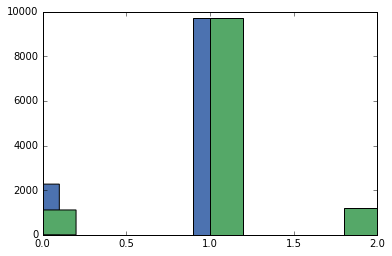

In [42]:
X = stochastic_drop(th.ones((50,4,3,20)), 0.2 , mode=None)
plt.hist(X.view(-1));
print("stochastic_drop biased", X.mean())
X = stochastic_drop_unbiased(th.ones((50,4,3,20)), 0.2 , mode=None)
plt.hist(X.view(-1));
print("stochastic_drop unbiased", X.mean())

mixup shape torch.Size([50, 4, 3, 20])
shake_drop 0.8983780889908473
mixup shape torch.Size([50, 4, 3, 20])
shake_drop_unbiased 0.9957496534685294


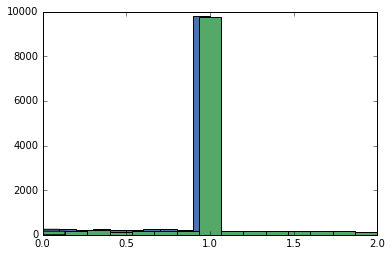

In [43]:

X = shake_drop(th.ones((50,4,3,20)), 0.2 , mode=None)
plt.hist(X.view(-1));
print("shake_drop", X.mean())
X = shake_drop_unbiased(th.ones((50,4,3,20)), 0.2 , mode=None)
plt.hist(X.view(-1), bins=15);
print("shake_drop_unbiased", X.mean())

In [106]:
def mixup_layer(X1, alpha,  mode=1, shuffle=True):
    return mixup(X1, alpha, betan,  mode=mode)
def mixup_layer_unbiased(X1, alpha, mode=1, shuffle=True):
    return mixup(X1, alpha, betapn,  mode=mode, shuffle=shuffle)

In [109]:
X = th.ones((50,4,3,20))
X = mixup_layer_unbiased(Variable(X), 0.2)
print(X.shape)


torch.Size([50, 4, 3, 20])


In [110]:
X.mean()

Variable containing:
 1
[torch.FloatTensor of size 1]

In [46]:
def dropout(X1, alpha, mode='channel'):
    return mixup(X1, alpha, binn, mode=mode)
def dropout_unbiased(X1, alpha, mode='channel'):
    return mixup(X1, alpha, binpn, mode=mode)
def dropout_unif(X1, alpha, mode='channel'):
    return mixup(X1, alpha, unifpn, mode=mode)
def dropout_beta(X1, alpha, mode='channel'):
    return mixup(X1, alpha, betapn, mode=mode)

In [ ]:
X = th.ones((50,20))
X = dropout(X, 0.2)
plt.hist(X.view(-1), bins=15);
print("mixup biased", X.mean())

mixup shape torch.Size([50, 20])
mixup biased 0.821
mixup shape torch.Size([50, 20])
mixup unbiased 1.001
mixup shape torch.Size([50, 20])
mixup unif unbiased 0.990348243355751
mixup shape torch.Size([50, 20])
mixup beta unbiased 0.9912717171907425


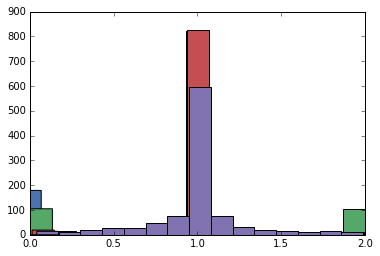

In [50]:
X = th.ones((50,20))
X = dropout(X, 0.2)
plt.hist(X.view(-1), bins=15);
print("mixup biased", X.mean())

X = th.ones((50,20))
X = dropout_unbiased(X, 0.2)
plt.hist(X.view(-1), bins=15);
print("mixup unbiased", X.mean())

X = th.ones((50,20))
X = dropout_unif(X, 0.2)
plt.hist(X.view(-1), bins=15);
print("mixup unif unbiased", X.mean())

X = th.ones((50,20))
X = dropout_beta(X, 0.2)
plt.hist(X.view(-1), bins=15);
print("mixup beta unbiased", X.mean())

In [51]:
import torchsample as ts

/Users/arunpatala/thenv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchsample.modules import ModuleTrainer
from torchsample.callbacks import EarlyStopping, ReduceLROnPlateau
from torchsample.regularizers import L1Regularizer, L2Regularizer
from torchsample.constraints import UnitNorm
from torchsample.initializers import XavierUniform
from torchsample.metrics import CategoricalAccuracy
from torchsample import TensorDataset
from torch.autograd import Variable

import os
from torchvision import datasets
ROOT = 'mnist'
dataset = datasets.MNIST(ROOT, train=True, download=True)
x_train, y_train = th.load(os.path.join(dataset.root, 'processed/training.pt'))
x_test, y_test = th.load(os.path.join(dataset.root, 'processed/test.pt'))

x_train = x_train.float()
y_train = y_train.long()
x_test = x_test.float()
y_test = y_test.long()

x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

# only train on a subset
#x_train = x_train[:10000]
#y_train = y_train[:10000]
#x_test = x_test[:1000]
#y_test = y_test[:1000]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
val_dataset = TensorDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define your model EXACTLY as if you were using nn.Module
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        if self.training: x = mixup_layer_unbiased(x, 0.1)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #if self.training: x = dropout_unif(x, 0.2)
        x = self.fc2(x)
        return F.log_softmax(x)


model = Network()
trainer = ModuleTrainer(model)

callbacks = [ReduceLROnPlateau(factor=0.5, patience=5)]
regularizers = [L1Regularizer(scale=1e-3, module_filter='conv*'),
                L2Regularizer(scale=1e-5, module_filter='fc*')]
constraints = [UnitNorm(frequency=3, unit='batch', module_filter='fc*')]
initializers = [XavierUniform(bias=False, module_filter='fc*')]
metrics = [CategoricalAccuracy(top_k=1)]

trainer.compile(loss='nll_loss',
                optimizer='adadelta',
                constraints=constraints,
                initializers=initializers,
                metrics=metrics, 
                callbacks=callbacks)

trainer.fit_loader(train_loader, val_loader, num_epoch=60, verbose=1)


  0%|          | 0/1875 [00:00<?, ? batches/s]/Users/arunpatala/thenv/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Epoch 1/60: 1876 batches [01:26,  1.97 batches/s, loss=0.14, lr=[1.0], val_acc=98.47, val_loss=0.0573, acc=93.22]
Epoch 2/60: 1876 batches [01:47, 17.37 batches/s, loss=0.0183, lr=[1.0], val_acc=98.97, val_loss=0.04, acc=95.79]
Epoch 3/60: 1876 batches [01:57,  1.03s/ batches, loss=0.0302, lr=[1.0], val_acc=98.98, val_loss=0.0448, acc=96.06]
Epoch 4/60: 1876 batches [01:58,  1.04 batches/s, loss=0.0704, lr=[1.0], val_acc=99.02, val_loss=0.0336, acc=96.20]
Epoch 5/60: 1876 batches [01:51,  1.46 batches/s, loss=0.00952, lr=[1.0], val_acc=99.05, val_loss=0.0421, acc=96.36]
Epoch 6/60: 1876 batches [01:51, 16.76 batches/s, loss=0.0363, lr=[1.0], val_acc=98.90, val_loss=0.0383, acc=96.28]
Epoch 7/60: 1876 batches [01:51,  1.74 batches/s, loss=0.2

In [97]:
X = Variable(random((3,4)))

In [100]:
X

Variable containing:
 0.7079  0.8122  0.4747  0.2893
 0.0529  0.2860  0.4836  0.0669
 0.1722  0.8933  0.3391  0.0574
[torch.FloatTensor of size 3x4]

In [80]:
X

Variable containing:
 0.6544  0.2849  0.4199  0.3139
 0.4665  0.4309  0.1897  0.2691
 0.0087  0.6961  0.5506  0.1508
[torch.FloatTensor of size 3x4]

In [75]:
P = th.randperm(len(X))